## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [5]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter('ignore')

In [6]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

## カテゴリデータのエンコーディング

In [7]:
df_number = df.select_dtypes(include="number")
df_category = df.select_dtypes(include="object")

display(pd.DataFrame(df_category.isnull().sum()).T)
display(df_category.head(1))

pd.DataFrame(df_category.nunique(), columns=["ユニーク数"])

,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Last_Update,url,img_url
0,0,0,0,32169,0,0,17,46606,0,0


,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Last_Update,url,img_url
0,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,/games/boxart/full_2258645AmericaFrontccc.jpg


,ユニーク数
Name,37102
basename,36672
Genre,20
ESRB_Rating,8
Platform,74
Publisher,3069
Developer,8064
Last_Update,430
url,55791
img_url,47601


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

### 全てOrdinalEncoding

In [9]:
# 数値データとカテゴリーデータに分ける
X_train_number = X_train.select_dtypes(include="number")
X_test_number = X_test.select_dtypes(include="number")

X_train_category = X_train.select_dtypes(include="object")
X_test_category = X_test.select_dtypes(include="object")

# index をリセット
X_train_number = X_train_number.reset_index(drop=True)
X_test_number = X_test_number.reset_index(drop=True)

X_train_category = X_train_category.reset_index(drop=True)
X_test_category = X_test_category.reset_index(drop=True)

In [10]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in X_train_category.columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train_category[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)

In [11]:
# エンコーディング設定
ode = OrdinalEncoder(
    handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
    unknown_value = -2,
    dtype = np.float64,
    categories = ordinal_all_cols_mapping
)

# OrdinalEncoderは欠損値があっても処理できるが、エンコーディングしないので欠損値を missing に置き換える
X_train_category = X_train_category.fillna("missing")
X_test_category = X_test_category.fillna("missing")

# エンコーディング
# trainデータは学習と変換、testデータは変換のみを実施。trainの学習パターン通りに変換するため
X_train_labels = ode.fit_transform(X_train_category)
X_test_labels = ode.transform(X_test_category)

# OrdinalEncoder は np.array型に変換してしまうため、DataFrame型で再構築する
X_train_oe = pd.DataFrame(
    X_train_labels,
    columns=X_train_category.columns
)

X_test_oe = pd.DataFrame(
    X_test_labels,
    columns=X_test_category.columns
)

# 数値データを結合
X_train_oe = pd.concat([X_train_oe, X_train_number ], axis=1)
X_test_oe = pd.concat([X_test_oe, X_test_number ], axis=1)

# 正規化
sc = StandardScaler()

X_train_oe = pd.DataFrame(
                            sc.fit_transform(X_train_oe),
                            columns=X_train_oe.columns
                            )

X_test_oe = pd.DataFrame(
                            sc.transform(X_test_oe),
                            columns=X_test_oe.columns
                            )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 15
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135113	Test's rmse: 0.235156


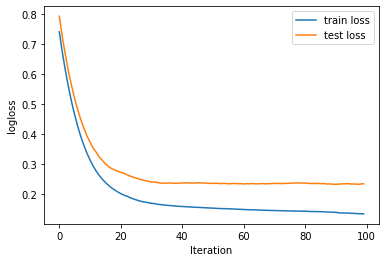

RMSE: 0.2351561219774193


In [12]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_oe, y_train)
lgb_test = lgb.Dataset(X_test_oe, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},  # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_oe)

# 精度評価
rmse_ode = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_ode)

## ユニーク数が少ない項目はOneHotEncoding、多い項目はOrdinalEncoding

In [13]:
# 数値データとカテゴリーデータに分ける
X_train_number = X_train.select_dtypes(include="number")
X_test_number = X_test.select_dtypes(include="number")

X_train_category = X_train.select_dtypes(include="object")
X_test_category = X_test.select_dtypes(include="object")

# index をリセット
X_train_number = X_train_number.reset_index(drop=True)
X_test_number = X_test_number.reset_index(drop=True)

X_train_category = X_train_category.reset_index(drop=True)
X_test_category = X_test_category.reset_index(drop=True)

# OneHotEncoderは欠損値があっても処理できるが、エンコーディングしないので欠損値を missing に置き換える
X_train_category = X_train_category.fillna("missing")
X_test_category = X_test_category.fillna("missing")

# ユニーク数に応じてカラムを分割する
category_unique_num = df.drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="object").nunique()
few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index

In [14]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_en = []

for column in many_kinds_category_columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train_category[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping_en.append(ordinal_one_cols_mapping)

In [15]:
# エンコーディング設定
ode = OrdinalEncoder(
    handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
    unknown_value = -1, # -2,
    dtype = np.float64,
    categories = ordinal_all_cols_mapping_en
)

ohe = OneHotEncoder(
    handle_unknown = 'ignore',
    sparse = False,
    dtype = np.int64,
    )

# エンコーディング
# trainデータは学習と変換、testデータは変換のみを実施。trainの学習パターン通りに変換するため

# OneHotEncoder
X_train_ohe_labels = ohe.fit_transform(X_train_category[few_kinds_category_columns])
X_test_ohe_labels = ohe.transform(X_test_category[few_kinds_category_columns ])

# OrdinalEncoder
X_train_ode_labels = ode.fit_transform(X_train_category[many_kinds_category_columns]) + 1
X_test_ode_labels = ode.transform(X_test_category[many_kinds_category_columns ]) + 1

# np.array型になってしまうため、DataFrame型で再構築する
# trainデータ
X_train_ode = pd.DataFrame(
    X_train_ode_labels,
    columns=X_train_category[many_kinds_category_columns].columns
)
X_train_ohe = pd.DataFrame(
    X_train_ohe_labels,
    columns=ohe.get_feature_names_out(few_kinds_category_columns)
)
X_train_en = pd.concat([X_train_ohe, X_train_ode], axis=1)

# testデータ
X_test_ode = pd.DataFrame(
    X_test_ode_labels,
    columns=X_test_category[many_kinds_category_columns].columns
)
X_test_ohe = pd.DataFrame(
    X_test_ohe_labels,
    columns=ohe.get_feature_names_out(few_kinds_category_columns)
)
X_test_en = pd.concat([X_test_ohe, X_test_ode], axis=1)


# 数値データを結合
X_train_en = pd.concat([X_train_en, X_train_number ], axis=1)
X_test_en = pd.concat([X_test_en, X_test_number ], axis=1)

# 正規化
sc = StandardScaler()
X_train_en = pd.DataFrame(
                            sc.fit_transform(X_train_en),
                            columns=X_train_en.columns
                            )

X_test_en = pd.DataFrame(
                            sc.transform(X_test_en),
                            columns=X_test_en.columns
                            )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2109
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 21
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130501	Test's rmse: 0.228831


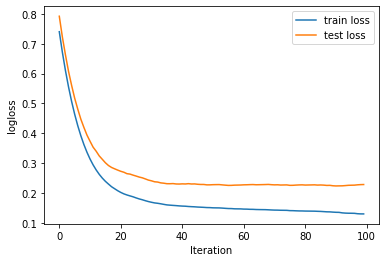

RMSE: 0.22883073440896592


In [16]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_en, y_train)
lgb_test = lgb.Dataset(X_test_en, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': {'rmse'},  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_en)

# 精度評価
rmse_en = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_en)

## Category_Encoders を使う

In [17]:
# ユニーク数に応じてカラムを分割する
category_unique_num = df.drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index

In [18]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)

In [19]:
# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データを壊さないようにコピーする
X_train_ce = X_train.copy()
X_test_ce = X_test.copy()

# 欠損値処理
category_columns = category_unique_num.index

X_train_ce[category_columns] = X_train_ce[category_columns].fillna("missing")
X_test_ce[category_columns] = X_test_ce[category_columns].fillna("missing")

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2266
[LightGBM] [Info] Number of data points in the train set: 13590, number of used features: 21
[LightGBM] [Info] Start training from score 0.366483
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134021	Test's rmse: 0.226488


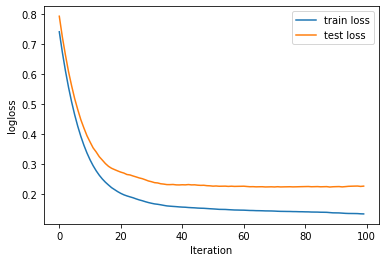

RMSE: 0.22648763368118405


In [20]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',                      # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰分類を指定
          'metric': {'rmse'},               # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()


# 推論
y_pred = model.predict(X_test_ce)

# 精度評価
rmse_ce = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_ce)

In [21]:
print("OrdinalEncodingのみ:", rmse_ode)
print("sklearn で OneHot+Ordinal Encoding:", rmse_en)
print("Category Encorders で OneHot+Ordinal Encoding:", rmse_ce)

OrdinalEncodingのみ: 0.2351561219774193
sklearn で OneHot+Ordinal Encoding: 0.22883073440896592
Category Encorders で OneHot+Ordinal Encoding: 0.22648763368118405


## Sklearn と Category_Encodings の処理結果をカラムごとに比較

In [22]:
for column_en, column_ce in zip(natsorted(X_train_en.columns), natsorted(X_train_ce.columns)):
    print(
        column_en,
        "min:", X_train_en[column_en].unique().min(), 
        "max:", X_train_en[column_en].unique().max(), 
        "length:", len(X_train_en[column_en].unique())
    )
    display(X_train_en.groupby(column_en).count().iloc[:, :1].T)

    print(
        column_ce,
        "min:", X_train_ce[column_ce].unique().min(), 
        "max:", X_train_ce[column_ce].unique().max(), 
        "length:", len(X_train_ce[column_ce].unique())
    )
    display(X_train_ce.groupby(column_ce).count().iloc[:, :1].T)
    print()

Critic_Score min: nan max: nan length: 83


Critic_Score,-4.290447,-4.081345,-4.011644,-3.941943,-3.802542,-3.663141,-3.593440,-3.384338,-3.314638,-3.244937,...,1.285605,1.355306,1.425007,1.494707,1.564408,1.634109,1.703809,1.773510,1.843210,1.982612
ESRB_Rating_E,2,1,1,2,1,1,6,1,2,5,...,72,43,31,26,16,20,7,4,2,3


Critic_Score min: nan max: nan length: 83


Critic_Score,-4.290447,-4.081345,-4.011644,-3.941943,-3.802542,-3.663141,-3.593440,-3.384338,-3.314638,-3.244937,...,1.285605,1.355306,1.425007,1.494707,1.564408,1.634109,1.703809,1.773510,1.843210,1.982612
Rank,2,1,1,2,1,1,6,1,2,5,...,72,43,31,26,16,20,7,4,2,3



Developer min: -1.7351311992952159 max: 1.6775196802133707 length: 2455


Developer,-1.735131,-1.733741,-1.732350,-1.730959,-1.729569,-1.728178,-1.726787,-1.725397,-1.724006,-1.722615,...,1.665004,1.666394,1.667785,1.669176,1.670566,1.671957,1.673348,1.674738,1.676129,1.677520
ESRB_Rating_E,1,2,1,1,2,2,12,1,1,1,...,1,1,1,2,4,6,1,1,13,2


Developer min: -1.7371251052310395 max: 1.6768565504042434 length: 2455


Developer,-1.737125,-1.734344,-1.732953,-1.731563,-1.730172,-1.728781,-1.727391,-1.726000,-1.724609,-1.723219,...,1.664341,1.665732,1.667122,1.668513,1.669903,1.671294,1.672685,1.674075,1.675466,1.676857
Rank,3,1,2,1,1,2,2,12,1,1,...,1,1,1,2,4,6,1,1,13,2



ESRB_Rating_E min: -0.658096341011341 max: 1.519534356418443 length: 2


ESRB_Rating_E,-0.658096,1.519534
ESRB_Rating_E10,9483,4107


ESRB_Rating_E min: -0.658096341011341 max: 1.519534356418443 length: 2


ESRB_Rating_E,-0.658096,1.519534
Rank,9483,4107



ESRB_Rating_E10 min: -0.3224600807163029 max: 3.101159057513819 length: 2


ESRB_Rating_E10,-0.322460,3.101159
ESRB_Rating_E,12310,1280


ESRB_Rating_E10 min: -0.3224600807163029 max: 3.101159057513819 length: 2


ESRB_Rating_E10,-0.322460,3.101159
Rank,12310,1280



ESRB_Rating_EC min: -0.03839061540937688 max: 26.048032555262218 length: 2


ESRB_Rating_EC,-0.038391,26.048033
ESRB_Rating_E,13570,20


ESRB_Rating_EC min: -0.03839061540937688 max: 26.048032555262218 length: 2


ESRB_Rating_EC,-0.038391,26.048033
Rank,13570,20



ESRB_Rating_M min: -0.34773148986900704 max: 2.8757821167611466 length: 2


ESRB_Rating_M,-0.347731,2.875782
ESRB_Rating_E,12124,1466


ESRB_Rating_M min: -0.34773148986900704 max: 2.8757821167611466 length: 2


ESRB_Rating_M,-0.347731,2.875782
Rank,12124,1466



ESRB_Rating_RP min: -0.04543778431032922 max: 22.008115386310177 length: 2


ESRB_Rating_RP,-0.045438,22.008115
ESRB_Rating_E,13562,28


ESRB_Rating_RP min: -0.04543778431032922 max: 22.008115386310177 length: 2


ESRB_Rating_RP,-0.045438,22.008115
Rank,13562,28



ESRB_Rating_T min: -0.5068892748509625 max: 1.9728174368929465 length: 2


ESRB_Rating_T,-0.506889,1.972817
ESRB_Rating_E,10812,2778


ESRB_Rating_T min: -0.5068892748509625 max: 1.9728174368929465 length: 2


ESRB_Rating_T,-0.506889,1.972817
Rank,10812,2778



ESRB_Rating_missing min: -0.6356655319092623 max: 1.5731543552415623 length: 2


ESRB_Rating_missing,-0.635666,1.573154
ESRB_Rating_E,9679,3911


ESRB_Rating_missing min: -0.6356655319092623 max: 1.5731543552415623 length: 2


ESRB_Rating_missing,-0.635666,1.573154
Rank,9679,3911



Genre min: -1.5100858953297744 max: 1.514372917232093 length: 20


Genre,-1.510086,-1.350904,-1.191722,-1.032540,-0.873358,-0.714176,-0.554994,-0.395812,-0.236630,-0.077448,0.081735,0.240917,0.400099,0.559281,0.718463,0.877645,1.036827,1.196009,1.355191,1.514373
ESRB_Rating_E,2047,178,1347,1,1,634,21,1608,91,20,661,521,989,1113,1,1064,795,1829,593,76


Genre min: -1.5100858953297744 max: 1.514372917232093 length: 20


Genre,-1.510086,-1.350904,-1.191722,-1.032540,-0.873358,-0.714176,-0.554994,-0.395812,-0.236630,-0.077448,0.081735,0.240917,0.400099,0.559281,0.718463,0.877645,1.036827,1.196009,1.355191,1.514373
Rank,2047,178,1347,1,1,634,21,1608,91,20,661,521,989,1113,1,1064,795,1829,593,76



Last_Update min: -3.6529481231856957 max: 0.4188343036068043 length: 332


Last_Update,-3.652948,-3.640647,-3.628345,-3.616044,-3.603742,-3.591441,-3.579139,-3.566838,-3.554536,-3.542235,...,0.308121,0.320423,0.332724,0.345026,0.357327,0.369628,0.381930,0.394231,0.406533,0.418834
ESRB_Rating_E,20,1,12,18,3,11,2,3,2,11,...,3,11,8,6,8,17,3,10,8,10929


Last_Update min: -0.40790671051300853 max: 3.9388001909539794 length: 332


Last_Update,-0.407907,-0.381722,-0.368629,-0.355537,-0.342444,-0.329352,-0.316259,-0.303167,-0.290074,-0.276982,...,3.820968,3.834060,3.847153,3.860245,3.873338,3.886430,3.899523,3.912615,3.925708,3.938800
Rank,10929,20,1,12,18,3,11,2,3,2,...,1,3,11,8,6,8,17,3,10,8



Name min: -1.7405271470866597 max: 1.7173294738846578 length: 10180


Name,-1.740527,-1.740187,-1.739848,-1.739508,-1.739168,-1.738829,-1.738489,-1.738149,-1.737810,-1.737470,...,1.714272,1.714612,1.714952,1.715291,1.715631,1.715971,1.716310,1.716650,1.716990,1.717329
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,2,...,3,1,1,1,1,1,1,1,1,2


Name min: -1.7405271470866597 max: 1.7173294738846578 length: 10180


Name,-1.740527,-1.740187,-1.739848,-1.739508,-1.739168,-1.738829,-1.738489,-1.738149,-1.737810,-1.737470,...,1.714272,1.714612,1.714952,1.715291,1.715631,1.715971,1.716310,1.716650,1.716990,1.717329
Rank,1,1,1,1,1,1,1,1,1,2,...,3,1,1,1,1,1,1,1,1,2



Platform min: -1.8602336750779578 max: 1.6587516304004004 length: 39


Platform,-1.860234,-1.767629,-1.675024,-1.582419,-1.489814,-1.397209,-1.304604,-1.212000,-1.119395,-1.026790,...,0.825308,0.917913,1.010517,1.103122,1.195727,1.288332,1.380937,1.473542,1.566147,1.658752
ESRB_Rating_E,4,419,90,35,1698,40,666,2,361,18,...,128,3,6,2,994,101,899,586,7,374


Platform min: -1.8602336750779578 max: 1.6587516304004004 length: 39


Platform,-1.860234,-1.767629,-1.675024,-1.582419,-1.489814,-1.397209,-1.304604,-1.212000,-1.119395,-1.026790,...,0.825308,0.917913,1.010517,1.103122,1.195727,1.288332,1.380937,1.473542,1.566147,1.658752
Rank,4,419,90,35,1698,40,666,2,361,18,...,128,3,6,2,994,101,899,586,7,374



Publisher min: -1.540335729215839 max: 1.7427261098477214 length: 648


Publisher,-1.540336,-1.535261,-1.530187,-1.525113,-1.520039,-1.514964,-1.509890,-1.504816,-1.499741,-1.494667,...,1.697058,1.702132,1.707206,1.712280,1.717355,1.722429,1.727503,1.732578,1.737652,1.742726
ESRB_Rating_E,4,83,24,119,1,30,1,65,4,3,...,1,3,4,4,1,1,3,1,2,2


Publisher min: -1.540335729215839 max: 1.7427261098477214 length: 648


Publisher,-1.540336,-1.535261,-1.530187,-1.525113,-1.520039,-1.514964,-1.509890,-1.504816,-1.499741,-1.494667,...,1.697058,1.702132,1.707206,1.712280,1.717355,1.722429,1.727503,1.732578,1.737652,1.742726
Rank,4,83,24,119,1,30,1,65,4,3,...,1,3,4,4,1,1,3,1,2,2



Rank min: -1.8422789359904337 max: 1.66987675503905 length: 13590


Rank,-1.842279,-1.840624,-1.839962,-1.838141,-1.837810,-1.837479,-1.837314,-1.837148,-1.836817,-1.834335,...,1.667063,1.667229,1.667394,1.667560,1.667725,1.668056,1.668718,1.669049,1.669546,1.669877
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Rank min: -1.8422789359904337 max: 1.66987675503905 length: 13590


Rank,-1.842279,-1.840624,-1.839962,-1.838141,-1.837810,-1.837479,-1.837314,-1.837148,-1.836817,-1.834335,...,1.667063,1.667229,1.667394,1.667560,1.667725,1.668056,1.668718,1.669049,1.669546,1.669877
Name,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1



Total_Shipped min: nan max: nan length: 1


Total_Shipped
ESRB_Rating_E


Total_Shipped min: nan max: nan length: 1


Total_Shipped
Rank



User_Score min: nan max: nan length: 38


User_Score,-4.697354,-4.316188,-3.325155,-1.876724,-1.648024,-1.419324,-1.343091,-1.266858,-1.038158,-0.961925,...,0.486507,0.562740,0.638973,0.715206,0.791440,0.867673,1.020139,1.096373,1.172606,1.248839
ESRB_Rating_E,1,1,1,1,3,1,1,2,1,1,...,3,4,12,9,3,4,3,5,1,1


User_Score min: nan max: nan length: 38


User_Score,-4.697354,-4.316188,-3.325155,-1.876724,-1.648024,-1.419324,-1.343091,-1.266858,-1.038158,-0.961925,...,0.486507,0.562740,0.638973,0.715206,0.791440,0.867673,1.020139,1.096373,1.172606,1.248839
Rank,1,1,1,1,3,1,1,2,1,1,...,3,4,12,9,3,4,3,5,1,1



VGChartz_Score min: nan max: nan length: 1


VGChartz_Score
ESRB_Rating_E


VGChartz_Score min: nan max: nan length: 1


VGChartz_Score
Rank



Vgchartzscore min: nan max: nan length: 53


Vgchartzscore,-3.255071,-3.110049,-2.892515,-2.747493,-2.529960,-2.384937,-2.312426,-2.167404,-2.094893,-2.022381,...,0.733042,0.805554,0.878065,0.950576,1.023087,1.095598,1.168109,1.240621,1.313132,1.458154
ESRB_Rating_E,3,2,2,1,6,2,1,1,1,1,...,13,10,6,11,4,17,8,4,8,3


Vgchartzscore min: nan max: nan length: 53


Vgchartzscore,-3.255071,-3.110049,-2.892515,-2.747493,-2.529960,-2.384937,-2.312426,-2.167404,-2.094893,-2.022381,...,0.733042,0.805554,0.878065,0.950576,1.023087,1.095598,1.168109,1.240621,1.313132,1.458154
Rank,3,2,2,1,6,2,1,1,1,1,...,13,10,6,11,4,17,8,4,8,3



Year min: nan max: nan length: 46


Year,-6.174758,-5.026604,-4.862582,-4.698560,-4.534538,-4.370515,-4.206493,-4.042471,-3.878449,-3.714427,...,0.550147,0.714169,0.878191,1.042213,1.206235,1.370258,1.534280,1.698302,1.862324,2.026346
ESRB_Rating_E,5,1,5,1,3,5,32,27,10,2,...,893,475,373,448,458,450,508,479,25,17


Year min: nan max: nan length: 46


Year,-6.174758,-5.026604,-4.862582,-4.698560,-4.534538,-4.370515,-4.206493,-4.042471,-3.878449,-3.714427,...,0.550147,0.714169,0.878191,1.042213,1.206235,1.370258,1.534280,1.698302,1.862324,2.026346
Rank,5,1,5,1,3,5,32,27,10,2,...,893,475,373,448,458,450,508,479,25,17



basename min: -1.7392009093276217 max: 1.7178556472432662 length: 10106


basename,-1.739201,-1.738859,-1.738517,-1.738175,-1.737832,-1.737490,-1.737148,-1.736806,-1.736464,-1.736122,...,1.714777,1.715119,1.715461,1.715803,1.716145,1.716487,1.716829,1.717171,1.717514,1.717856
ESRB_Rating_E,1,1,1,1,1,1,2,1,2,1,...,1,1,1,2,1,1,1,1,1,1


basename min: -1.7392009093276217 max: 1.7178556472432662 length: 10106


basename,-1.739201,-1.738859,-1.738517,-1.738175,-1.737832,-1.737490,-1.737148,-1.736806,-1.736464,-1.736122,...,1.714777,1.715119,1.715461,1.715803,1.716145,1.716487,1.716829,1.717171,1.717514,1.717856
Rank,1,1,1,1,1,1,2,1,2,1,...,1,1,1,2,1,1,1,1,1,1



img_url min: -1.7083967433678162 max: 1.7639822219369767 length: 13184


img_url,-1.708397,-1.708133,-1.707870,-1.707607,-1.707343,-1.707080,-1.706816,-1.706553,-1.706290,-1.706026,...,1.761612,1.761875,1.762138,1.762402,1.762665,1.762929,1.763192,1.763455,1.763719,1.763982
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


img_url min: -1.7083967433678162 max: 1.7639822219369767 length: 13184


img_url,-1.708397,-1.708133,-1.707870,-1.707607,-1.707343,-1.707080,-1.706816,-1.706553,-1.706290,-1.706026,...,1.761612,1.761875,1.762138,1.762402,1.762665,1.762929,1.763192,1.763455,1.763719,1.763982
Rank,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1



status min: 0.0 max: 0.0 length: 1


status,0.0
ESRB_Rating_E,13590


status min: 0.0 max: 0.0 length: 1


status,0.0
Rank,13590



url min: -1.7319233618671066 max: 1.7319233618671066 length: 13590


url,-1.731923,-1.731668,-1.731414,-1.731159,-1.730904,-1.730649,-1.730394,-1.730139,-1.729884,-1.729629,...,1.729629,1.729884,1.730139,1.730394,1.730649,1.730904,1.731159,1.731414,1.731668,1.731923
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


url min: -1.7319233618671066 max: 1.7319233618671066 length: 13590


url,-1.731923,-1.731668,-1.731414,-1.731159,-1.730904,-1.730649,-1.730394,-1.730139,-1.729884,-1.729629,...,1.729629,1.729884,1.730139,1.730394,1.730649,1.730904,1.731159,1.731414,1.731668,1.731923
Rank,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
